# Integrate the equations of motion of particles in a potential

The goal of this notebook is simple: to calculate the trajectory of particles in an arbitrary potential. The potential will be specified as a Pytorch function, and the forces on the particles will be calculated using automatic differentiation.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

In [2]:
def integrate_path(force_fn, x0, v0, t_max, **kwargs):
    assert x0.shape == v0.shape

    n_particles, n_dim = x0.shape
    s = (x0.size,)

    def dy_dt(t, y):
        y = np.reshape(y, (2, n_particles, n_dim))
        x, x_t = y
        x_tt = force_fn(t, x)
        y_t = np.concatenate([np.reshape(x_t, s), np.reshape(x_tt, s)])
        return y_t

    y0 = np.concatenate([np.reshape(x0, s), np.reshape(v0, s)])

    sol = solve_ivp(dy_dt, (0.,t_max), y0, **kwargs)

    x,v = np.reshape(sol.y, (2, n_particles, n_dim, sol.y.shape[1]))

    return sol, x, v

# Harmonic Oscillator

Here, we specify the force explicitly:
$$
  \vec{F} \left( \vec{x} \right) = -\vec{x} \, .
$$

In [3]:
force_fn = lambda t, x: -x

x0 = np.random.uniform(-1., 1., size=(32,3))
v0 = np.random.uniform(-1., 1., size=(32,3))
t_max = 10.

sol,x,v = integrate_path(
    force_fn, x0, v0, t_max,
    t_eval=np.arange(0.,t_max,0.1)
)

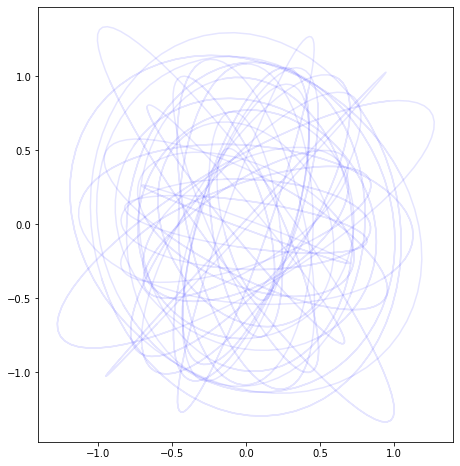

In [4]:
fig,ax = plt.subplots(1,1, figsize=(8,8), subplot_kw=dict(aspect='equal'))
for xx in x:
    ax.plot(xx[0], xx[1], c='b', alpha=0.1)
plt.show()

In [5]:
import torch
from torch.autograd import Variable
print(f'Pytorch version {torch.__version__}')

Pytorch version 1.5.1+cu101


# Calculate forces using auto-differentiation

We calculate forces using
$$
  \vec{F} = -\nabla \Phi \, .
$$
We just need to specify $\Phi \left( \vec{x} \right)$ as a Pytorch function.

In [6]:
def calc_force(phi_func, x):
    phi = phi_func(x)[:,None]
    dphi_dx = torch.autograd.grad(phi, x,\
                                grad_outputs=torch.ones_like(phi), retain_graph=True,\
                                create_graph=True)[0]
    return -dphi_dx

def calc_force_np(phi_func, x):
    x = Variable(torch.from_numpy(x), requires_grad=True)
    return calc_force(phi_func, x).detach().numpy()

In [7]:
def phi_grav(x):
    r = torch.sqrt(torch.sum(x**2, axis=1))
    return -1/r

def phi_plummer(x):
    r2 = torch.sum(x**2, axis=1)
    return -(1 + r2)**(-1/2)

In [8]:
def draw_from_sphere(n):
    phi = np.random.uniform(0., 2*np.pi, size=n)
    theta = np.arccos(np.random.uniform(-1., 1., size=n))
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)
    return np.stack([x,y,z], axis=1)

In [9]:
n = 2048
t_max = 30.

force_fn = lambda t, x: calc_force_np(phi_plummer, x)

x0 = np.random.uniform(-1., 1., size=(n,3))

E_grav = phi_plummer(torch.from_numpy(x0)).numpy()
v_max = np.sqrt(-2*E_grav)
v0 = v_max * np.random.uniform(size=(n,))
v0 = v0[:,None] * draw_from_sphere(n)

sol,x,v = integrate_path(
    force_fn, x0, v0, t_max,
    t_eval=np.arange(0.,t_max+0.001,0.1)
)

print(sol.message)

The solver successfully reached the end of the integration interval.


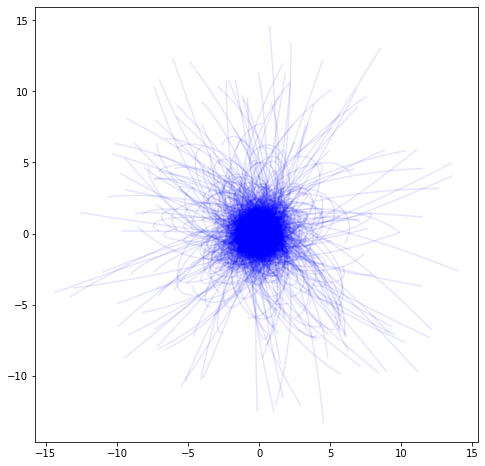

In [10]:
fig,ax = plt.subplots(1,1, figsize=(8,8), subplot_kw=dict(aspect='equal'))
for xx in x:
    ax.plot(xx[0], xx[1], c='b', alpha=0.1)
plt.show()

(array([  7.,   4.,   5.,   1.,  17.,   3.,  11.,   4.,   8.,  15.,  13.,
         22.,  40., 106., 388., 745., 395., 103.,  42.,  18.,  17.,   9.,
          7.,  10.,  13.,   4.,   6.,   5.,   2.,   4.,   3.]),
 array([-10.        ,  -9.35483871,  -8.70967742,  -8.06451613,
         -7.41935484,  -6.77419355,  -6.12903226,  -5.48387097,
         -4.83870968,  -4.19354839,  -3.5483871 ,  -2.90322581,
         -2.25806452,  -1.61290323,  -0.96774194,  -0.32258065,
          0.32258065,   0.96774194,   1.61290323,   2.25806452,
          2.90322581,   3.5483871 ,   4.19354839,   4.83870968,
          5.48387097,   6.12903226,   6.77419355,   7.41935484,
          8.06451613,   8.70967742,   9.35483871,  10.        ]),
 <a list of 31 Patch objects>)

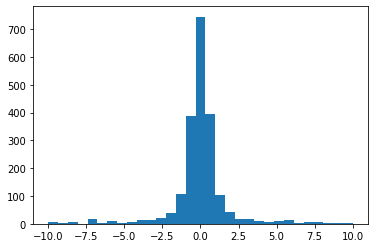

In [11]:
plt.hist(x[:,0,300], bins=31, range=(-10., 10.))

(array([  1.,   4.,   2.,   0.,  10.,  16.,  32.,  49.,  47.,  76., 113.,
         94., 125., 160., 204., 187., 181., 168., 128., 126.,  85.,  61.,
         63.,  45.,  24.,  15.,  13.,   8.,   6.,   4.,   1.]),
 array([-1.        , -0.93548387, -0.87096774, -0.80645161, -0.74193548,
        -0.67741935, -0.61290323, -0.5483871 , -0.48387097, -0.41935484,
        -0.35483871, -0.29032258, -0.22580645, -0.16129032, -0.09677419,
        -0.03225806,  0.03225806,  0.09677419,  0.16129032,  0.22580645,
         0.29032258,  0.35483871,  0.41935484,  0.48387097,  0.5483871 ,
         0.61290323,  0.67741935,  0.74193548,  0.80645161,  0.87096774,
         0.93548387,  1.        ]),
 <a list of 31 Patch objects>)

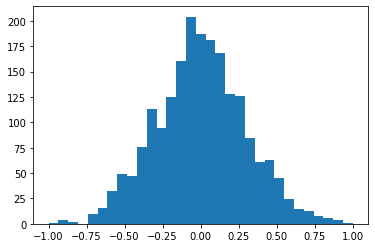

In [12]:
plt.hist(v[:,0,300], bins=31, range=(-1., 1.))

In [13]:
from matplotlib import animation
from progressbar import ProgressBar

In [14]:
fig,ax = plt.subplots(1,1, figsize=(8,8), subplot_kw=dict(aspect='equal'), dpi=160)
sc = ax.scatter(x[:,0,0], x[:,1,0], c='b', alpha=0.1, edgecolors='none')
ax.set_xlim(-5., 5.)
ax.set_ylim(-5., 5.)

bar = ProgressBar(max_value=x.shape[-1])

def update_plot(i):
    bar.update(i)
    sc.set_offsets(x[:,:2,i])
    return sc,

anim = animation.FuncAnimation(
    fig,
    update_plot,
    frames=x.shape[-1],
    blit=False,
    repeat=False
)

anim.save('plummer_trajectories.mp4', fps=30)

plt.close(fig)

 99% (300 of 301) |##################### | Elapsed Time: 0:00:22 ETA:   0:00:00